In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Data Science Eugene Pinsky/Homework_11/Decision tree/data/NVDA_mean_volatility_labels.csv")
df.head()

,Year,Week_Number,mean_return,volatility,Label
0,2017,1,0.28275,2.110070,undefined
1,2017,2,0.08460,2.299927,undefined
2,2017,3,0.15750,2.164153,undefined
3,2017,4,1.45160,0.704763,undefined
4,2017,5,0.48560,2.413944,undefined


Extracting data for both years.

In [3]:
year_1_data = df[ df["Year"] == 2020 ]
year_1_data = year_1_data.reset_index(drop=True)

year_2_data = df[ df["Year"] == 2021 ]
year_2_data = year_2_data.reset_index(drop=True)

Getting training data.

In [4]:
X_train,y_train = year_1_data[[ "Year",	"Week_Number",	"mean_return", "volatility" ]] , year_1_data[["Label"]]

Getting test data.

In [5]:
X_test,y_test = year_2_data[[ "Year",	"Week_Number",	"mean_return", "volatility" ]] , year_2_data[["Label"]]

Helper functions.

In [6]:
def compute_accuracy(y_true,y_pred,model_name):
  
  #computing accuracy
  accuracy = accuracy_score(y_true,y_pred)

  accuracy_message = "The accuracy of the " + str(model_name) +" model is : " + str(round(accuracy * 100, 2)) + " %."

  print(accuracy_message)

In [7]:
def compute_conf_mat(y_true,y_pred):

  #computing confusion matrix
  conf_mat = confusion_matrix(y_true,y_pred)

  #computing true positive rate and false negative rate
  tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
  #calcultaing true positive rate
  tpr = tp/(tp+fn)
  #calcultaing true negative rate
  tnr = tn/(fp+tn)

  #displaying confusion matrix
  ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

  return tpr,tnr

In [8]:
def print_tpr_tnr(tpr,tnr,model_name):

  #printing true positive rate and true negative rate
  tpr_message = "The true positive rate for the " +  str( model_name ) + " model  is : " + str(round(tpr*100,2)) +" %."
  tnr_message = "The true negative rate for the " +  str( model_name ) + " model  is : " + str(round(tnr*100,2)) +" %."

  print(tpr_message)
  print("\n")
  print(tnr_message)

### Q1.

In [9]:
model = DecisionTreeClassifier()
model.fit(X_train[["mean_return", "volatility"]],y_train.values.ravel())
y_pred = model.predict( X_test[["mean_return", "volatility"]] )

compute_accuracy(y_test,y_pred,"Decision Tree classifier")

The accuracy of the Decision Tree classifier model is : 65.38 %.


### Q2.

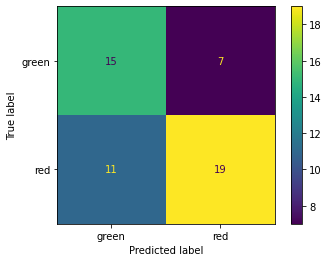

In [10]:
tpr,tnr= compute_conf_mat(y_test,y_pred)

### Q3.

In [11]:
print_tpr_tnr(tpr,tnr,"Decision Tree Classifier")

The true positive rate for the Decision Tree Classifier model  is : 63.33 %.


The true negative rate for the Decision Tree Classifier model  is : 68.18 %.


### Q4.

Trading Strategies

In [12]:
#function to carry out inertia trading strategy
def buy_and_hold(df,principal,end):

    #quantity of shares bought at opening price
    shares_bought = 0

    #amount gained by selling stock at closing price
    amount_gained = 0

    #value achieved from selling stocks at closing price at the end of given period.
    capital = 0 

    #buying stocks at start opening price at the start of the year.
    shares_bought = principal/df["Open"][0]

    #selling stock at its closing price
    capital = shares_bought * df["Close"][end]

    return capital

In [13]:
#function to carry out buy with label weekly trading strategy
def buy_with_labels(df,end):

  #cash amount initially used to invest in stock market
  initial_cash = 100

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  #value achieved from selling stocks at closing price at the end of given period.
  capital = 0 

  #boolean variable to determine if . 
  invested = False

  #iterating through dataframe
  for index,row in df.iterrows():
 
   #Finding first green week or green week after a red week ,and we dont have a position in market yet.
    if df["Label"][index] == "green" and invested ==False :
      
      #buying shares equal to the amount of cash we hold currently 
      shares_bought = initial_cash / df["Open"][index]
      
      #as we have bought shares equal in evaluation to our cash initial cash = 0
      initial_cash = 0

      #we have a position in the market
      invested = True

    #Finding red week where we dont have a position
    elif df["Label"][index] == "red" and invested ==False :
      
      #we do nothing
      continue

    #conditions if we have put money in the market

    #check to see we are not at the last day of trading.
    if index!= end:

      #if next week is red and current week is green
      if invested == True and df["Label"][index] == "green" and df["Label"][index+1] == "red":

        #selling stock at adjusted closing price at the end of the week
        initial_cash += df["Adj Close"][index] * shares_bought
        
        #all shares are sold
        shares_bought = 0
        
        #we are no longer invested in the market.
        invested = False

      #if current week is green and (next week/next day) is green 
      elif invested == True and df["Label"][index] == "green" and df["Label"][index+1] == "green":

        #do nothing
        continue

    #if we end our trading period while being invested in the market
    if index == end and invested == True:
        
        #selling stock at adjusted closing price at the end of the week
        initial_cash += df["Adj Close"][index] * shares_bought
        
        #all shares are sold
        shares_bought = 0

        #we are no longer invested in the market.
        invested = False
  
  #returning the updated cash
  return initial_cash

Getting daily data.

function to combine weekly predictions to daily data, to use for trading.

In [14]:
def label_daily_data(daily_data,weekly_data,weekly_labels):
  
  #weekly_data holds weekly data for year 2, weekly_labels holds predictions from Gaussian Naive Bayes model.
  weekly_data = pd.concat([weekly_data,pd.DataFrame(weekly_labels)],axis=1)
  
  #renaming columns so that Label column can be changed from default(0) to Label.
  weekly_data.columns = ["Year", "Week_Number",	"mean_return",	"volatility",	"Label"]

  daily_data = pd.merge(daily_data,weekly_data[["Week_Number","Label"]],on="Week_Number")

  return daily_data


In [15]:
df_daily = pd.read_csv("/content/drive/MyDrive/Data Science Eugene Pinsky/Homework_11/Decision tree/data/NVDA.csv")

year_2_data_daily = df_daily[ df_daily["Year"] == 2021 ]

year_2_data_daily = year_2_data_daily.reset_index(drop=True)

year_2_data_daily.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2021-01-04 00:00:00-05:00,2021,1,4,Monday,1,2021-01,131.04,136.52,129.62,131.13,56064000,130.93,0.004481,131.436429,132.4336
1,2021-01-05 00:00:00-05:00,2021,1,5,Tuesday,1,2021-01,131.00,134.43,130.87,134.05,32276000,133.84,0.022210,131.505000,132.4432
2,2021-01-06 00:00:00-05:00,2021,1,6,Wednesday,1,2021-01,132.23,132.45,125.86,126.14,58042400,125.95,-0.058953,130.972857,132.2492
3,2021-01-07 00:00:00-05:00,2021,1,7,Thursday,1,2021-01,129.68,133.78,128.87,133.44,46148000,133.23,0.057830,131.045000,132.2904
4,2021-01-08 00:00:00-05:00,2021,1,8,Friday,1,2021-01,133.62,134.21,130.42,132.77,29252800,132.56,-0.005040,130.998571,132.2672


merging labelled weekly data with daily data.

In [16]:
year_2_data_daily = label_daily_data(year_2_data_daily,X_test,y_pred)
year_2_data_daily.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label
0,2021-01-04 00:00:00-05:00,2021,1,4,Monday,1,2021-01,131.04,136.52,129.62,131.13,56064000,130.93,0.004481,131.436429,132.4336,red
1,2021-01-05 00:00:00-05:00,2021,1,5,Tuesday,1,2021-01,131.00,134.43,130.87,134.05,32276000,133.84,0.022210,131.505000,132.4432,red
2,2021-01-06 00:00:00-05:00,2021,1,6,Wednesday,1,2021-01,132.23,132.45,125.86,126.14,58042400,125.95,-0.058953,130.972857,132.2492,red
3,2021-01-07 00:00:00-05:00,2021,1,7,Thursday,1,2021-01,129.68,133.78,128.87,133.44,46148000,133.23,0.057830,131.045000,132.2904,red
4,2021-01-08 00:00:00-05:00,2021,1,8,Friday,1,2021-01,133.62,134.21,130.42,132.77,29252800,132.56,-0.005040,130.998571,132.2672,red


Trading using buy and hold and buy with labels.

In [17]:
capital = buy_and_hold(year_2_data_daily,100,len(year_2_data_daily)-1)
print("The capital from investing 100 dollars in buy and hold is as follows: " + str(round(capital,2)))

The capital from investing 100 dollars in buy and hold is as follows: 225.78


In [18]:
#return on investment
roi = buy_with_labels(year_2_data_daily,len(year_2_data_daily)-1)
print("The cash with us after investing using buy with labels strategy is: "+str(round(roi,2)))

The cash with us after investing using buy with labels strategy is: 320.38
